In [201]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import scipy
import functools as ft
import random

X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.identity(2)

In [202]:
n = 8
b = [1 for i in range(n)]
b2 = [random.random()*3 for i in range(n-1)]

def get_gi(gate, i, get_gi1=False):
    gates = []
    for j in range(n):
        if j == i or (j == i+1 and get_gi1):
            gates.append(gate)
        else:
            gates.append(I)
    return ft.reduce(np.kron, gates)

h1 = sum(b2[i]*(get_gi(X, i, True) + get_gi(Y, i, True)) for i in range(n-1))

h2 = sum((b[i] * get_gi(Z, i)) for i in range(n))

h = h1 + h2

def u(t):
    return scipy.linalg.expm(-1j * h * t)

#print(h1)
#print(h)

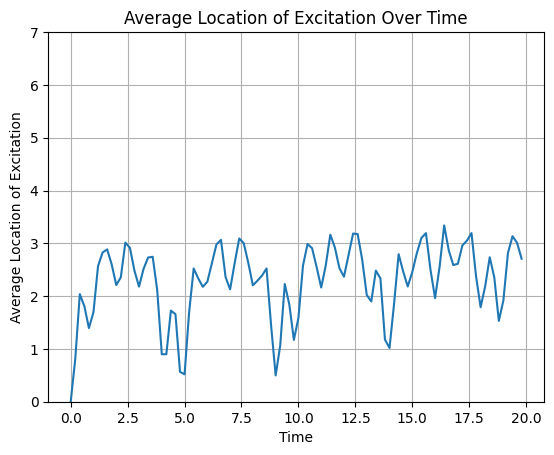

In [203]:
simulator = Aer.get_backend('aer_simulator')
r = np.arange(0, 20, .2)
shots = 1000
avg_locations = []

for t in r:
    qc = QuantumCircuit(n)
    qc.x(0) # create state with 1 qubit in the |1> state

    qc.unitary(u(t), range(n))
    qc.measure_all()

    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=shots)
    result = job.result()
    counts = dict(result.get_counts())

    avg_location = 0
    for bitstring, freq in sorted(counts.items(), key=lambda x: x[1], reverse=True):
        location = n-1-bitstring.index('1')
        avg_location += location * freq / shots
        #print(f"{bitstring.replace("0", "-")}: {freq}", end='; ')
    #print(avg_location)
    avg_locations.append(avg_location)

plt.plot(r, avg_locations)
plt.xlabel('Time')
plt.ylabel('Average Location of Excitation')
plt.ylim(0, n-1)
plt.title('Average Location of Excitation Over Time')
plt.grid()
plt.show()